In [2]:
import requests
from bs4 import BeautifulSoup as soup
from matplotlib import pyplot as plt
from datetime import datetime, timedelta
import csv
import pandas as pd

In [3]:
  def scrape_covid_data(page, print_length=False):

    datas = list()
    dose1 = list()
    dose2 = list()
    conf = list()
    ativ = list()
    obt = list()

    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 '
                             '(KHTML, like Gecko) Chrome/86.0.4240.111 Safari/537.36 Edg/86.0.622.51'}
    url = f'https://muriae.mg.gov.br/{page}/'

    request = requests.get(url, headers=headers)
    page_soup = soup(request.content, 'html.parser')

    conteudo = page_soup.body.div.text.split()

    chaves = ['Epidemiológico']

    for n, palavra in enumerate(conteudo):
        if palavra == 'Epidemiológico':
            string = conteudo[n + 2][0:10]
            d_type = datetime.strptime(string, '%d/%m/%Y')
            datas.append(d_type)
            conteudo.pop(n)
        elif palavra == 'Epidemiológico-':
            string = conteudo[n + 1][0:10]
            d_type = datetime.strptime(string, '%d/%m/%Y')
            datas.append(d_type)
            conteudo.pop(n)
        elif ('Boletim' in conteudo[n] and conteudo[n + 1] == '-') \
        or (conteudo[n] == 'Covid' and conteudo[n+1] == '-'):
            string = conteudo[n + 2][0:5:] + '/2021'
            d_type = datetime.strptime(string, '%d/%m/%Y')
            datas.append(d_type)
            conteudo.pop(n)
        elif (palavra == 'confirmados:') or (palavra == 'covid-19:'):
            inteiro = int(conteudo[n + 1].replace('.', ''))
            conf.append(inteiro)
            conteudo.pop(n)
        elif palavra == 'ativos:':
            ativ.append(int(conteudo[n + 1].replace('Pacientes', '')))
            conteudo.pop(n)
        elif 'Óbitos:' in palavra:
            obt.append(int(conteudo[n + 1].replace('Investigados', '')))
            conteudo.pop(n)
        elif ('Primeira' in conteudo[n] and conteudo[n+1] == 'dose:') or \
                            (conteudo[n] == 'uma' and conteudo[n+1] == 'dose:') or \
                            ( 'uma' in conteudo[n] and conteudo[n+1] == 'dose):') or \
                            ('Parcialmente' in conteudo[n] and conteudo[n+1] == 'vacinados:'):
            dose1.append(int(conteudo[n + 2].replace('Vacinados', '').replace('.', '')))
            conteudo.pop(n)
        elif palavra == 'doses:' or palavra == 'única:' or palavra == 'única):':
            dose2.append(int(conteudo[n + 1].replace('PACIENTESTotal', '').replace('.', '')))
            conteudo.pop(n)
        elif 'Segunda' in conteudo[n] and conteudo[n+1] == 'dose:' or \
                    ( 'Totalmente' in conteudo[n] and conteudo[n+1] == 'vacinados:'):
            dose2.append(int(conteudo[n+2].replace('.','')))
            conteudo.pop(n)
        else:
            pass
    if print_length:
        print(len(datas), len(dose1), len(dose2), len(conf), len(ativ), len(obt))
    
    d = {'Data': datas, 'Dose 1': dose1, 'Dose 2': dose2,
     'Casos Totais': conf, 'Casos Ativos': ativ, 'Óbitos': obt}

    df = pd.DataFrame(data=d)
    
    return df

In [4]:
#a prefeitura remove os boletins depois de algum tempo, é necessário usar um backup
def backup_concat(df):
    bkup = pd.read_csv('covid-muriae-auto.csv', sep=';', encoding='utf8')

    bkup['Data'] = [datetime.strptime(data, '%Y-%m-%d') for data in bkup['Data']]

    #filtra os registros do backup que já estão no df oriundo de scrape
    bkup = bkup.loc[[data not in df['Data'].values for data in bkup['Data']]]
    bkup.reset_index(drop=True, inplace=True)
    
    #dataframe ainda faltando dias não letivos
    df = pd.concat([bkup, df[::-1]], axis=0).drop(['Casos Diários', 'Óbitos Diários'], axis=1)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [10]:
#combinar com um date range da primeira data até hoje
def merge_time_range_df(df):
    global hoje
    inicio, hoje = datetime(2020, 5, 19), datetime.today().date()
    intervalo = pd.date_range(inicio, hoje)
    
    d2 = {'Data': intervalo}
    df2 = pd.DataFrame(data=d2)

    joined = pd.merge(df2, df, on='Data', how='left').fillna(0)

    joined[['Dose 1', 'Dose 2', 'Casos Totais', 'Casos Ativos', 'Óbitos']] = \
        joined[['Dose 1', 'Dose 2', 'Casos Totais', 'Casos Ativos', 'Óbitos']].astype('int')
    
    return joined

In [6]:
# transformando os dados zeros em dados do dia anterior para um gráfico mais harmônico
def replace_0_with_last_data(joined):
    c = 1
    nao_zero = int()
    while True:

        for i, value in enumerate(joined.iloc[:, c]):
            if value != 0:
                nao_zero = value
            else:
                if joined.loc[i, joined.columns[0]] != hoje:
                    joined.loc[i, joined.columns[c]] = nao_zero
                else:
                    joined.drop(i, inplace=True)
        else:
            c += 1
            nao_zero = int()
            if c == len(joined.columns):
                break

    joined.at[456, 'Óbitos'] = 301


    joined['Casos Diários'] = joined['Casos Totais'].diff().fillna(0).astype('int')
    joined['Óbitos Diários'] = joined['Óbitos'].diff().fillna(0).astype('int')

    pd.set_option('display.max_columns', len(joined.columns))

    return joined

In [11]:
df = (scrape_covid_data(page='coronavirus').pipe(backup_concat)
                                           .pipe(merge_time_range_df)
                                           .pipe(replace_0_with_last_data))

In [12]:
df

,Data,Dose 1,Dose 2,Casos Totais,Casos Ativos,Óbitos,Casos Diários,Óbitos Diários
0,2020-05-19,0,0,67,39,3,0,0
1,2020-05-20,0,0,77,49,3,10,0
2,2020-05-21,0,0,83,45,4,6,1
3,2020-05-22,0,0,95,57,4,12,0
4,2020-05-23,0,0,95,57,4,0,0
...,...,...,...,...,...,...,...,...
527,2021-10-28,84248,59439,11871,10,316,1,0
528,2021-10-29,84278,59718,11874,11,316,3,0
529,2021-10-30,84278,59718,11874,11,316,0,0
530,2021-10-31,84278,59718,11874,11,316,0,0


In [20]:
def plotar_casosVSimun(save=False, show=True):
    from numpy import max
    plt.figure(figsize=(1080 / 600, 1080 / 600), dpi=600)
    ax = plt.axes()
    ax.set(facecolor='#c6e2ff')
    plt.plot(df['Data'], df['Dose 1'], color='#8dae56', linewidth=0.5, label='Dose 1 da Vacina')
    plt.plot(df['Data'], df['Dose 2'], color='green', linewidth=0.5, label='Dose 2 e dose única da Vacina')
    plt.subplots_adjust(top=0.86, bottom=0.1, left=0.15, right=0.96)
    plt.xticks(df['Data'][::60], fontsize=2, rotation=20, y=0.04)
    plt.xlim(min(df['Data']), max(df['Data']))
    plt.ylim(0, max(df['Dose 1'] + 16000))
    plt.yticks(range(0, max(df['Dose 1']), 6000), fontsize=3, x=0.03)
    plt.ylabel('Doses', fontsize=2, labelpad=0.8)
    plt.legend(loc='upper right', fontsize=2)
    
    ax2 = plt.gca().twinx()
    plt.ylabel('Casos Ativos', fontsize=2, labelpad=0.8)
    plt.yticks(fontsize=2)
    plt.xlim(min(df['Data']), max(df['Data']) + timedelta(days=1))
    plt.ylim(0, max(df['Casos Ativos'] + 20))
    plt.plot(df['Data'], df['Casos Ativos'], color='orange', linewidth=0.5)
    plt.title('Casos Ativos vs Doses aplicadas em Muriaé \n'
              'segundo os boletins epidemiológicos da \n'
              'Prefeitura de Muriaé', fontsize=2.5, y=0.96)
    plt.tight_layout()
    if save:
        
        plt.savefig('Gráficos/ativos-vs-imunizados.png')
        
    else:
        pass

    if show:
        plt.show()
    else:
        pass


def plotar_casosAtivos(save=False, show=True):
    from numpy import max, min

    plt.figure(figsize=(1080 / 600, 1080 / 600), dpi=600)
    ax = plt.axes()
    ax.set(facecolor='#c6e2ff')
    plt.plot(df['Data'], df['Casos Ativos'], color='orange', linewidth=0.5)
    plt.xlim(min(df['Data']), max(df['Data']) + timedelta(days=1))
    plt.subplots_adjust(top=0.86, bottom=0.1, left=0.15, right=0.96)
    plt.ylim(0, max(df['Casos Ativos']+20))
    plt.yticks(range(0, max(df['Casos Ativos']), 45), fontsize=3, x=0.03)
    plt.xticks(df['Data'][::60], fontsize=2.5, rotation=20, y=0.04)
    plt.ylabel('Casos Ativos', fontsize=6, labelpad=0.47)
    plt.title(
        'Evolução dos Casos Ativos de COVID-19 em Muriaé \n '
        'segundo os boletins epidemiológicos \n da '
        'Prefeitura de Muriaé', fontsize=4, y=0.96
    )

    if save:
        plt.savefig('Gráficos/casos_ativos.png', dpi=600)
    else:
        pass

    if show:
        plt.show()
    else:
        pass


def plotar_obitos(save=False, show=True):
    from numpy import max

    plt.figure(figsize=(1080 / 600, 1080 / 600), dpi=600)
    ax = plt.axes()
    ax.set(facecolor='#c6e2ff')
    plt.bar(df['Data'], df['Óbitos Diários'], color='red', width=1)
    plt.subplots_adjust(top=0.86, bottom=0.1, left=0.15, right=0.96)
    plt.yticks(range(0, max(df['Óbitos Diários']) + 1), fontsize=3, x=0.02)
    plt.xlim(min(df['Data']), max(df['Data']) + timedelta(days=1))
    plt.xticks(df['Data'][::90], fontsize=2.5, rotation=20, y=0.04)
    plt.ylabel('Óbitos Diários', fontsize=6, labelpad=0.48)
    plt.title(
        'Óbitos diários por COVID-19 em Muriaé \n '
        'segundo os boletins epidemiológicos \n '
        'da Prefeitura de Muriaé', fontsize=4, y=0.96
    )

    if save:
        plt.savefig('Gráficos/covid_obitos.png', dpi=600)
    else:
        pass

    if show:
        plt.show()
    else:
        pass


def plotar_casos_diarios(save=False, show=True):
    from numpy import max

    plt.figure(figsize=(1080 / 600, 1080 / 600), dpi=600)
    ax = plt.axes()
    ax.set(facecolor='#c6e2ff')
    plt.bar(df['Data'], df['Casos Diários'], color='blue')
    plt.subplots_adjust(top=0.86, bottom=0.1, left=0.15, right=0.96)
    plt.yticks(range(0, max(df['Casos Diários']), 20), fontsize=3, x=0.02)
    plt.xticks(df['Data'][::60], fontsize=2.5, rotation=20, y=0.04)
    plt.xlim(min(df['Data']), max(df['Data']) + timedelta(days=1))
    plt.ylabel('Casos Diários', fontsize=6, labelpad=0.48)
    plt.title(
        'Casos Diários de COVID-19 em Muriaé \n '
        'segundo os boletins epidemiológicos \n da '
        'Prefeitura de Muriaé', fontsize=4, y=0.96
    )

    if save:
        plt.savefig('Gráficos/casos_diarios.png', dpi=600)
    else:
        pass

    if show:
        plt.show()
    else:
        pass

def relacao_ativosObtos(save=False, show=True):
    plt.figure(figsize=(12,12))
    ax = plt.axes()
    ax.set(facecolor='#c6e2ff')
    plt.bar(df['Data'], df['Óbitos Diários'], color='red')
    plt.ylabel('Óbitos diários', fontsize=16)
    plt.yticks(fontsize=14)
    ax2 = plt.gca().twinx()
    plt.ylabel('Casos Ativos', fontsize=16)
    plt.yticks(fontsize=14)
    plt.xlim(min(df['Data']), max(df['Data']) + timedelta(days=1))
    plt.plot(df['Data'], df['Casos Ativos'], color='blue')

    if save:
        plt.savefig('Gráficos/casos_obitos.png')
    else:
        pass

    if show:
        plt.show()
    else:
        pass
    

In [14]:
df.to_csv('covid-muriae-auto.csv', encoding='utf-8', sep=';', index=False)

In [15]:
plt.rcParams.update({'figure.facecolor': '#92b69e'})
plt.rcParams['axes.linewidth'] = 0.1

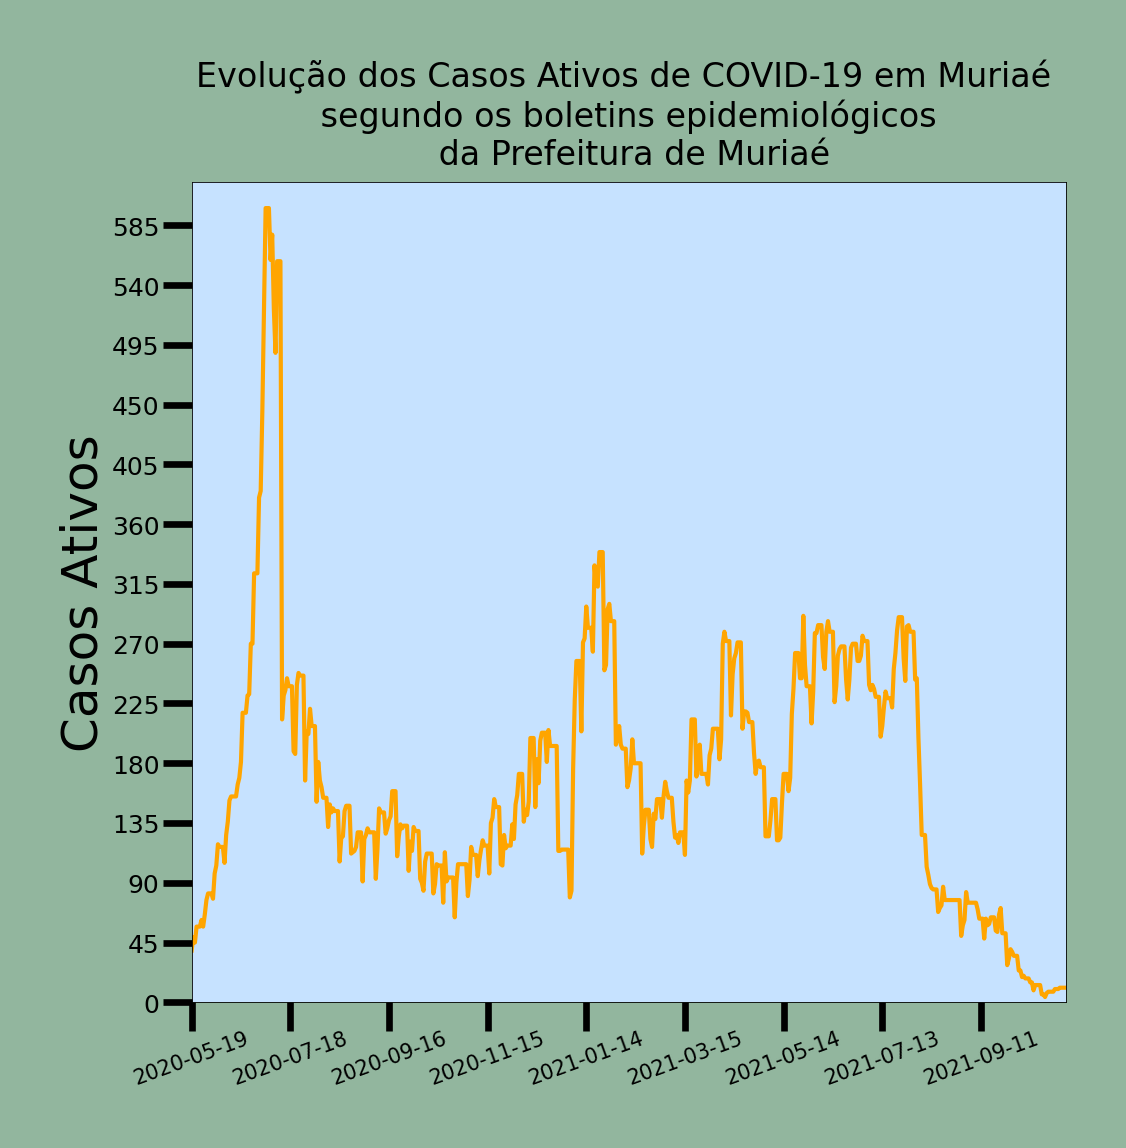

In [18]:
plotar_casosAtivos(save=True)

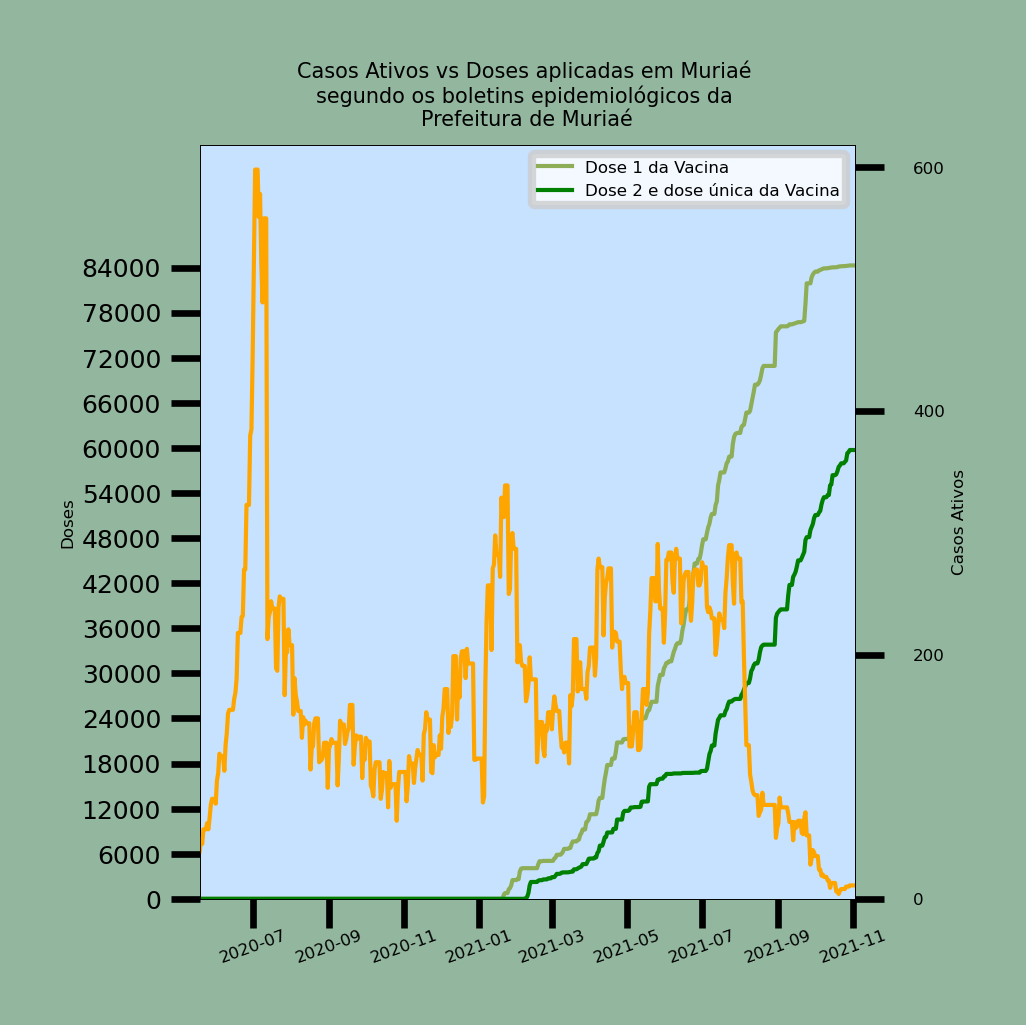

In [21]:
plotar_casosVSimun(save=True)

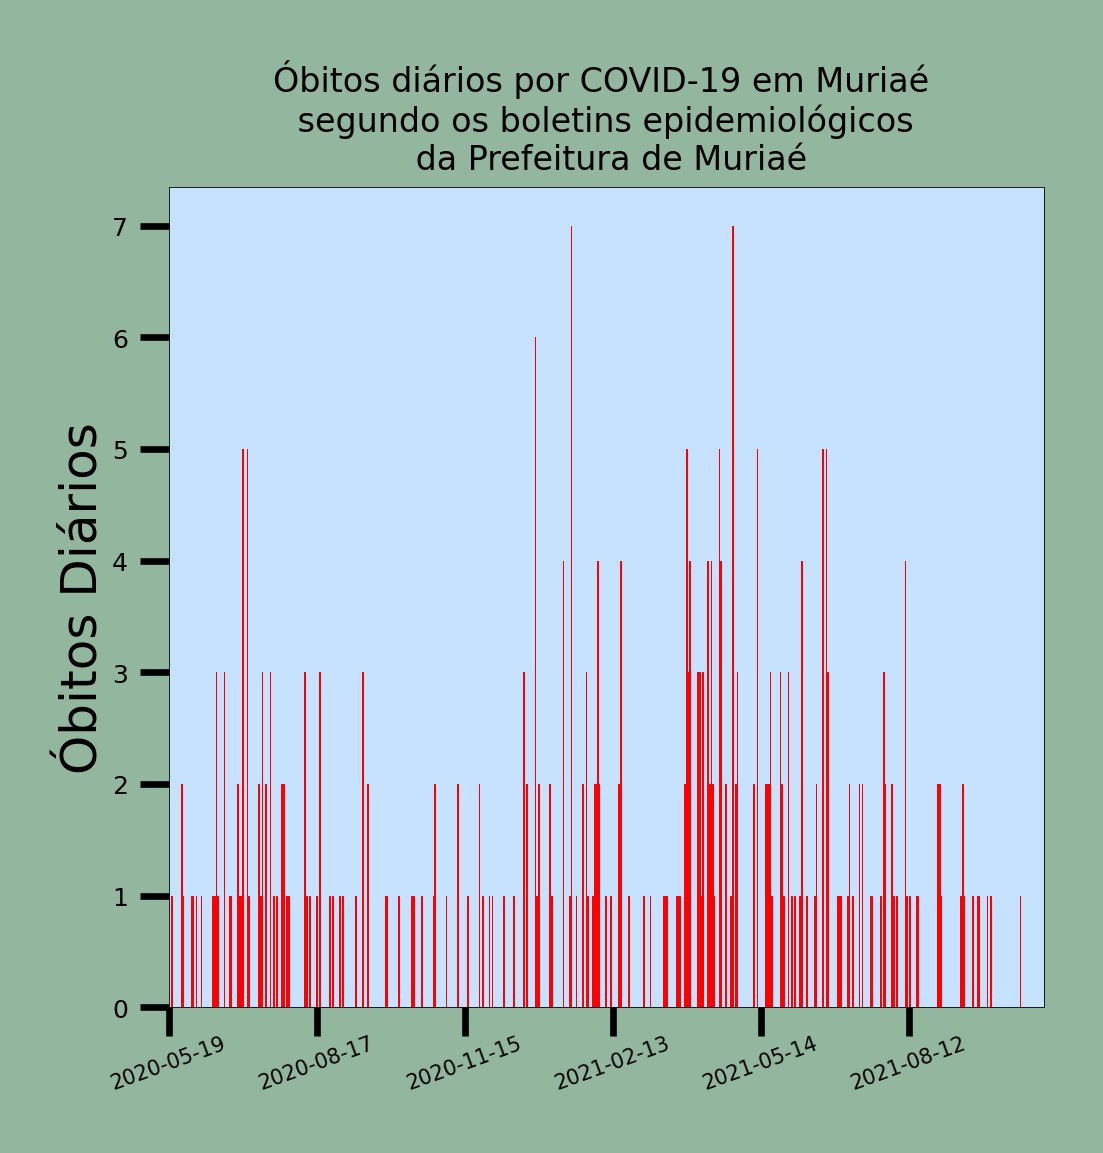

In [22]:
plotar_obitos(save=True)

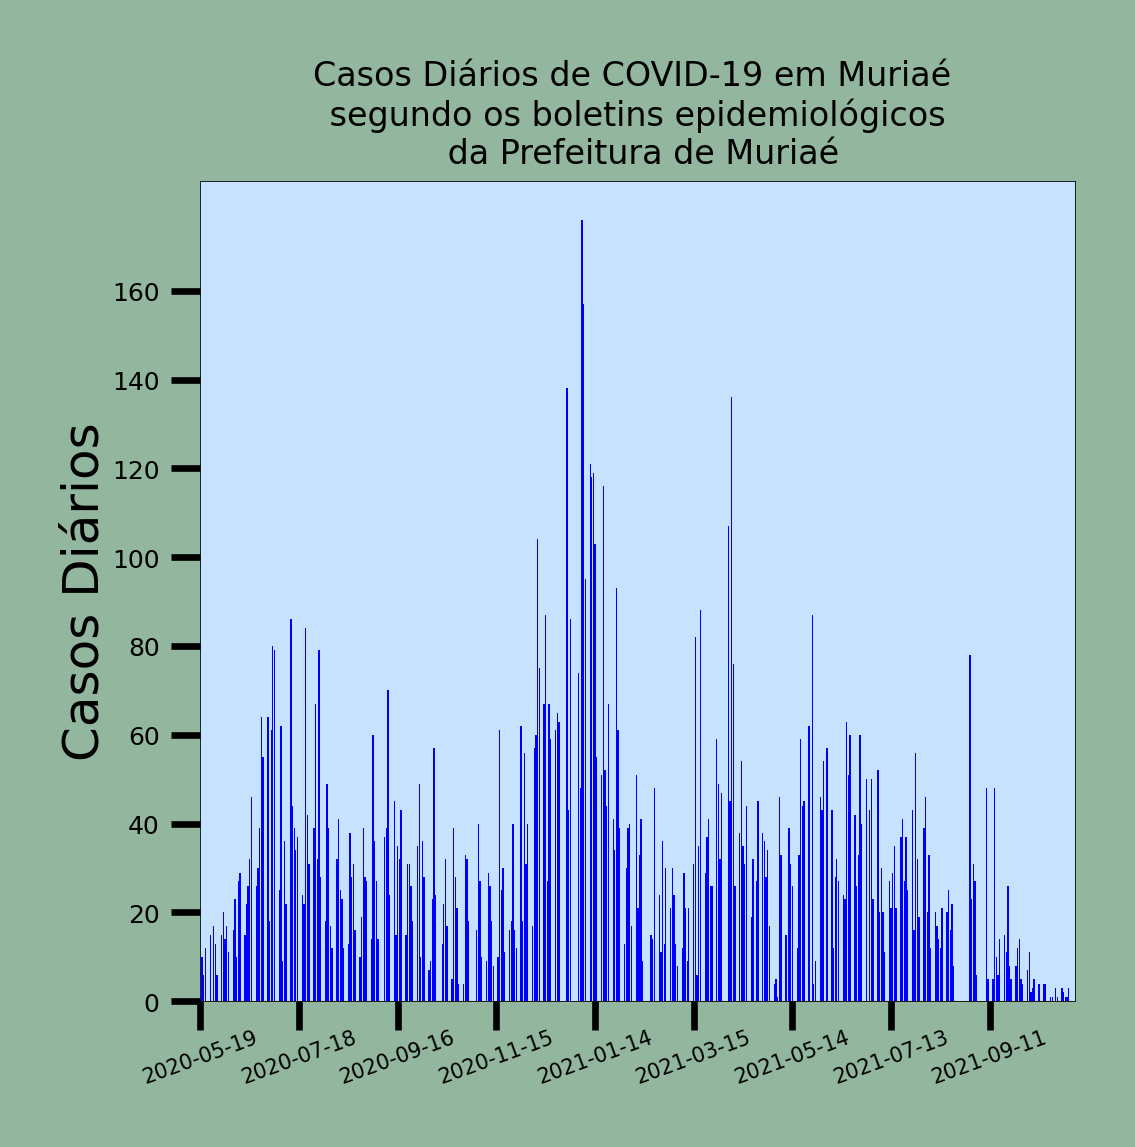

In [23]:
plotar_casos_diarios(save=True)

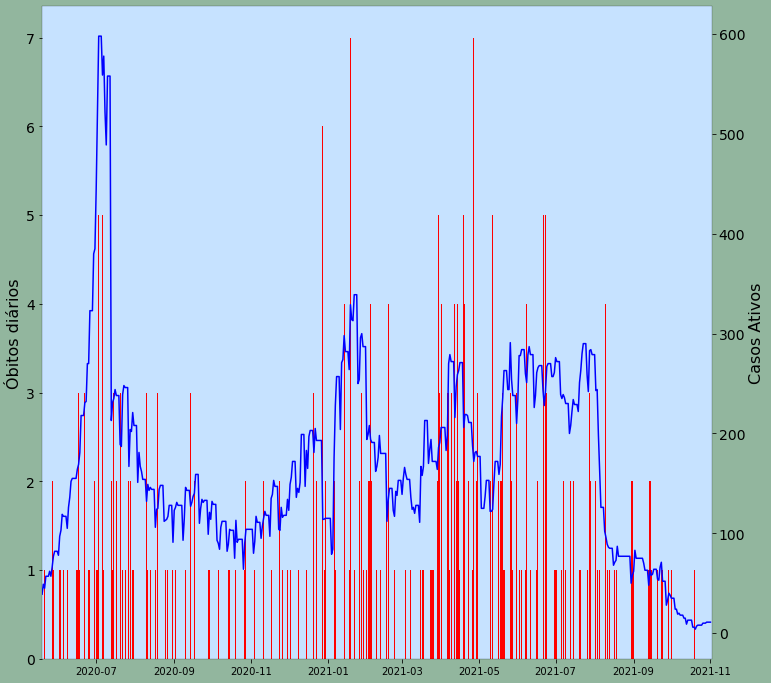

In [24]:
relacao_ativosObtos(save=True)